In [43]:
# =============================
# Core libraries
# =============================
import numpy as np
import pandas as pd

# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# Sklearn Imports
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
# =============================
from scipy.stats import pearsonr

# Utilities
# =============================
import joblib
import warnings
warnings.filterwarnings('ignore')

In [44]:
df = pd.read_excel('mpuData.xlsx')
df.head()

,Attempet_ID,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ
0,1,Stretching,True,1,Shoulder,-0.25,-0.01,-0.02,0.01,9.78
1,1,Stretching,True,1,Elbow,0.91,-0.17,-0.03,0.00,9.77
2,1,Stretching,True,1,Wrist,0.57,-0.12,-0.02,0.03,9.75
3,1,Stretching,True,1,Hand,0.71,-0.11,-0.04,0.05,9.72
4,1,Stretching,True,1,Shoulder,0.25,-0.07,-0.02,0.02,9.77


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Attempet_ID     628 non-null    int64  
 1   Movement_Name   628 non-null    object 
 2   Movement_Label  628 non-null    bool   
 3   Label_Value     628 non-null    int64  
 4   Joint_Label     628 non-null    object 
 5   Pitch           628 non-null    float64
 6   Roll            628 non-null    float64
 7   AccelX          628 non-null    float64
 8   AccelY          628 non-null    float64
 9   AccelZ          628 non-null    float64
dtypes: bool(1), float64(5), int64(2), object(2)
memory usage: 44.9+ KB


In [46]:
# =============================
# 4. Session Reconstruction (NO SORTING)
# =============================
# Preserve natural time order
df['Natural_ID'] = (
    (df['Attempet_ID'] != df['Attempet_ID'].shift()) |
    (df['Movement_Name'] != df['Movement_Name'].shift()) |
    (df['Label_Value'] != df['Label_Value'].shift())
).cumsum()

print(f"Total reconstructed sessions: {df['Natural_ID'].nunique()}")

Total reconstructed sessions: 22


In [47]:
# =============================
# 5. Time Alignment for Joints
# =============================
# Create time index per joint per session
df['TimeStep'] = df.groupby(['Natural_ID', 'Joint_Label']).cumcount()

# Pivot: synchronize 4 joints into one row
df_pivoted = df.pivot_table(
    index=['Natural_ID', 'Movement_Name', 'Label_Value', 'TimeStep'],
    columns='Joint_Label',
    values=['Pitch', 'Roll', 'AccelX', 'AccelY', 'AccelZ']
).sort_index()

# Flatten column names
df_pivoted.columns = [
    f"{sensor}_{joint}" for sensor, joint in df_pivoted.columns
]

df_pivoted = df_pivoted.reset_index()

print("Joint synchronization completed")


Joint synchronization completed


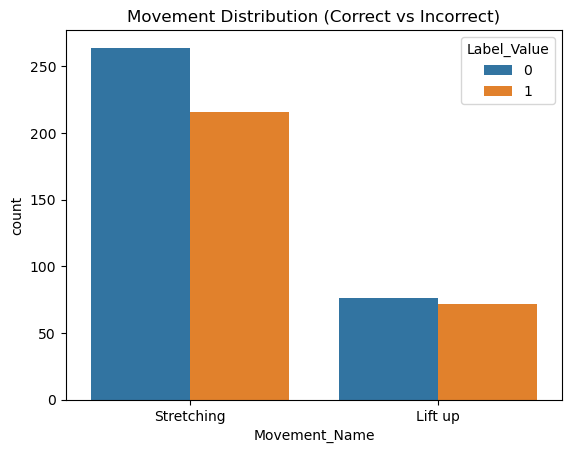

In [48]:
sns.countplot(x='Movement_Name', hue='Label_Value', data=df)
plt.title('Movement Distribution (Correct vs Incorrect)')
plt.show()

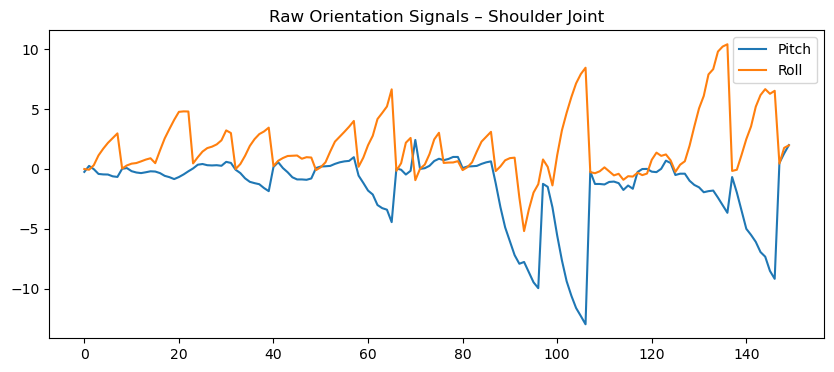

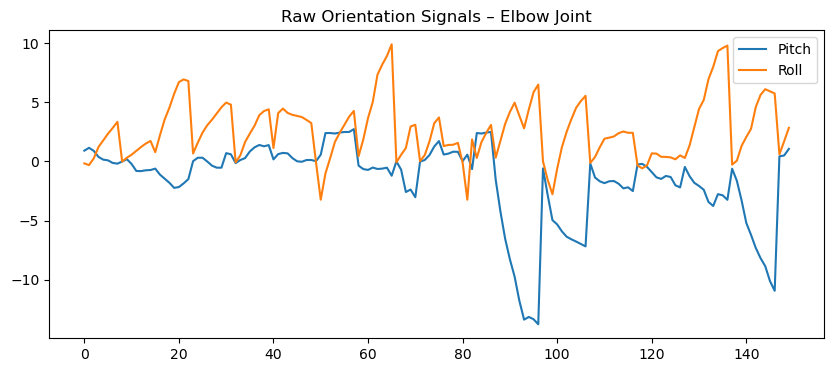

In [49]:
sample = df[df['Joint_Label'] == 'Shoulder'].iloc[:300]
plt.figure(figsize=(10,4))
plt.plot(sample['Pitch'].values[:150], label='Pitch')
plt.plot(sample['Roll'].values[:150], label='Roll')
plt.legend()
plt.title('Raw Orientation Signals – Shoulder Joint')
plt.show()
sample = df[df['Joint_Label'] == 'Elbow'].iloc[:300]
plt.figure(figsize=(10,4))
plt.plot(sample['Pitch'].values[:150], label='Pitch')
plt.plot(sample['Roll'].values[:150], label='Roll')
plt.legend()
plt.title('Raw Orientation Signals – Elbow Joint')
plt.show()

In [50]:
# =============================
# 6. Feature Engineering (Window-Based)
# =============================
WINDOW_SIZE = 5
STEP = 2

X = []
y = []
groups = []

sensor_features = [
    col for col in df_pivoted.columns
    if any(x in col for x in ['Pitch', 'Roll', 'Accel'])
]

for session_id, session_df in df_pivoted.groupby('Natural_ID'):
    label = session_df['Label_Value'].iloc[0]

    for i in range(0, len(session_df) - WINDOW_SIZE + 1, STEP):
        window = session_df.iloc[i:i + WINDOW_SIZE]
        features = {}

        # --- Statistical Features ---
        for col in sensor_features:
            features[f'{col}_mean'] = window[col].mean()
            features[f'{col}_std']  = window[col].std()

        # --- Coordination Feature (Medical Logic) ---
        if 'Pitch_Shoulder' in window and 'Pitch_Elbow' in window:
            corr, _ = pearsonr(window['Pitch_Shoulder'], window['Pitch_Elbow'])
            features['Coord_Shoulder_Elbow'] = 0 if np.isnan(corr) else corr

        # --- Smoothness (Jerk Approximation) ---
        if 'AccelZ_Hand' in window:
            jerk = window['AccelZ_Hand'].diff().fillna(0).mean()
            features['Hand_Smoothness'] = jerk

        X.append(list(features.values()))
        y.append(label)
        groups.append(session_id)

X = np.nan_to_num(np.array(X))
y = np.array(y)
groups = np.array(groups)

print(f"Total extracted windows: {len(X)}")

Total extracted windows: 39


In [51]:
# =============================
# 7. Train / Test Split (Group-Aware)
# =============================
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train_raw, X_test_raw = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train = groups[train_idx]

print(f"Training attempts: {len(np.unique(groups_train))}")
print(f"Testing attempts: {len(np.unique(groups[test_idx]))}")

# =============================
# 8. Scaling
# =============================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

Training attempts: 15
Testing attempts: 4


In [52]:
# =============================
# 9. Define Models
# =============================
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=300, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=300, random_state=42),
    'XGBoost':XGBClassifier(
    scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
)
}

In [53]:
# =============================
# 10. Model Selection (Group CV)
# =============================
results = []
cv = GroupKFold(n_splits=5)

print("\nRunning Group Cross-Validation...")

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        groups=groups_train,
        cv=cv,
        scoring='f1'
    )

    results.append({
        'Model': name,
        'CV_F1_Mean': scores.mean(),
        'CV_F1_Std': scores.std(),
        'Model_Object': model
    })

results_df = pd.DataFrame(results).sort_values(by='CV_F1_Mean', ascending=False)
print(results_df[['Model', 'CV_F1_Mean', 'CV_F1_Std']])


Running Group Cross-Validation...


                 Model  CV_F1_Mean  CV_F1_Std
1        Random Forest    0.528571   0.365893
3              XGBoost    0.514286   0.259775
0  Logistic Regression    0.460000   0.407922
2             AdaBoost    0.404762   0.349278


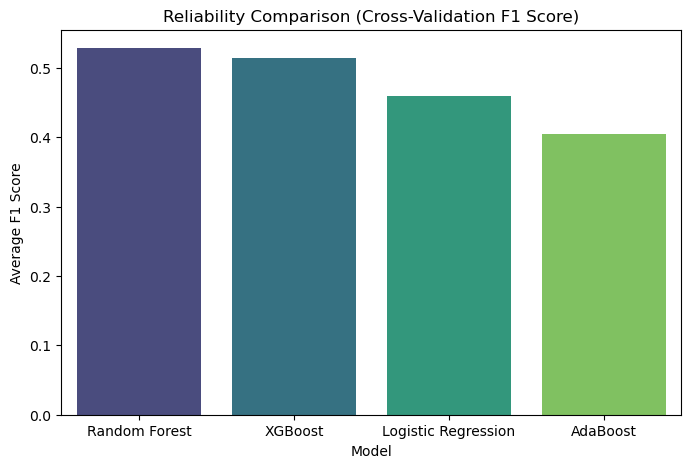

In [54]:
# Visual Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='CV_F1_Mean', data=results_df, palette='viridis')
plt.title('Reliability Comparison (Cross-Validation F1 Score)')
plt.ylabel('Average F1 Score')
plt.show()


Best Model Selected: Random Forest

Final Evaluation on Unseen Attempts
Accuracy: 0.7777777777777778
F1 Score: 0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.50      0.50      0.50         2

    accuracy                           0.78         9
   macro avg       0.68      0.68      0.68         9
weighted avg       0.78      0.78      0.78         9



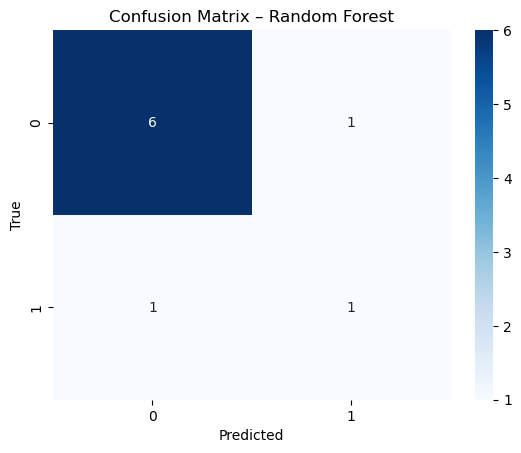

In [55]:
# =============================
# 11. Final Training & Evaluation
# =============================
best_model = results_df.iloc[0]['Model_Object']
best_model_name = results_df.iloc[0]['Model']

print(f"\nBest Model Selected: {best_model_name}")

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("\nFinal Evaluation on Unseen Attempts")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix – {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [56]:
# =============================
# 12. Save Artifacts
# =============================
feature_names = [f"f_{i}" for i in range(X.shape[1])]

joblib.dump(best_model, 'best_mpu_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(feature_names, 'feature_list.joblib')

print("\nAll artifacts saved successfully.")


All artifacts saved successfully.
